In [22]:
import torch
import torchvision
from torchvision import transforms
from torchinfo import summary
import matplotlib.pyplot as plt
from torch import  nn
from going_modular.going_modular import data_setup, engine
from helper_functions import set_seeds, plot_loss_curves
from going_modular.going_modular.predictions import pred_and_plot_image


In [2]:
# get GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Setup directory paths to train and test images
train_dir = "./data/pizza_steak_sushi/train/"
test_dir = "./data/pizza_steak_sushi/test/"

 ![](/app/pytorch_zero/08-vit-paper-mapping-the-four-equations-to-figure-1.png)

In [3]:
# prepare transforms for images
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor() ])

# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir, test_dir=test_dir, transform=manual_transforms, 
    batch_size=BATCH_SIZE )


In [4]:
# Visualize a single image
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

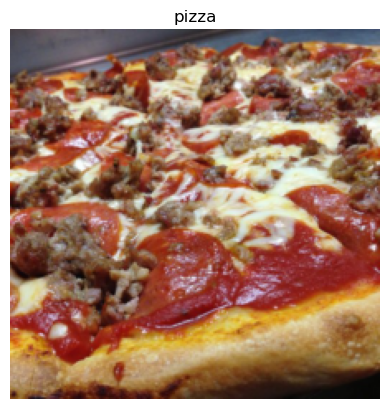

In [5]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

We'll use a patch size ($P$) of 16 since it's the best performing version of ViT-Base uses (see column "ViT-B/16" of Table 5 in the ViT paper for more).

In [6]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [7]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


## Putting it all together to create ViT

$$
\begin{aligned}
\mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & &
\end{aligned}
$$

Don't worry, we can put equation 4 into our overall ViT architecture class.

All we need is a `torch.nn.LayerNorm()` layer and a `torch.nn.Linear()` layer to convert the 0th index ($\mathbf{z}_{L}^{0}$) of the Transformer Encoder logit outputs to the target number of classes we have.

To create the full architecture, we'll also need to stack a number of our `TransformerEncoderBlock`s on top of each other, we can do this by passing a list of them to `torch.nn.Sequential()` (this will make a sequential range of `TransformerEncoderBlock`s).

We'll focus on the ViT-Base hyperparameters from Table 1 but our code should be adaptable to other ViT variants.

Creating ViT will be our biggest code block yet but we can do it!

Finally, to bring our own implementation of ViT to life, let's:

1. Create a class called `ViT` that inherits from `torch.nn.Module`.
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Make sure the image size is divisible by the patch size (the image should be split into even patches).
4. Calculate the number of patches using the formula $N=H W / P^{2}$, where $H$ is the image height, $W$ is the image width and $P$ is the patch size.
5. Create a learnable class embedding token (equation 1) as done above in section 4.6.
6. Create a learnable position embedding vector (equation 1) as done above in section 4.7.
7. Setup the embedding dropout layer as discussed in Appendix B.1 of the ViT paper.
8. Create the patch embedding layer using the `PatchEmbedding` class as above in section 4.5.
9. Create a series of Transformer Encoder blocks by passing a list of `TransformerEncoderBlock`s created in section 7.1 to `torch.nn.Sequential()` (equations 2 & 3).
10. Create the MLP head (also called classifier head or equation 4) by passing a `torch.nn.LayerNorm()` (LN) layer and a `torch.nn.Linear(out_features=num_classes)` layer (where `num_classes` is the target number of classes) linear layer to `torch.nn.Sequential()`.
11. Create a `forward()` method that accepts an input.
12. Get the batch size of the input (the first dimension of the shape).
13. Create the patching embedding using the layer created in step 8 (equation 1).
14. Create the class token embedding using the layer created in step 5 and expand it across the number of batches found in step 11 using [`torch.Tensor.expand()`](https://pytorch.org/docs/stable/generated/torch.Tensor.expand.html) (equation 1).
15. Concatenate the class token embedding created in step 13 to the first dimension of the patch embedding created in step 12 using [`torch.cat()`](https://pytorch.org/docs/stable/generated/torch.cat.html) (equation 1).
16. Add the position embedding created in step 6 to the patch and class token embedding created in step 14 (equation 1).
17. Pass the patch and position embedding through the dropout layer created in step 7.
18. Pass the patch and position embedding from step 16 through the stack of Transformer Encoder layers created in step 9 (equations 2 & 3).
19. Pass index 0 of the output of the stack of Transformer Encoder layers from step 17 through the classifier head created in step 10 (equation 4).
20. Dance and shout woohoo!!! We just built a Vision Transformer!

In [8]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    #Turns a 2D input image into a 1D sequence learnable embedding vector.

    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [9]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


### Replicating Equation 2 with PyTorch layers

In [10]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

### Replicating Equation 3 with PyTorch layers

In [11]:
class MLPBlock(nn.Module):
    
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self, embedding_dim, mlp_size, dropout):
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) ) # "Dropout, when used, is applied after every dense layer.."        

    
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [12]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

## build model

In [14]:
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [15]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [16]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [17]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1708025831440/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
 10%|█         | 1/10 [00:04<00:38,  4.22s/it]

Epoch: 1 | train_loss: 5.3100 | train_acc: 0.3672 | test_loss: 5.1928 | test_acc: 0.2604


 20%|██        | 2/10 [00:07<00:29,  3.64s/it]

Epoch: 2 | train_loss: 1.9300 | train_acc: 0.3438 | test_loss: 1.6644 | test_acc: 0.2604


 30%|███       | 3/10 [00:10<00:24,  3.49s/it]

Epoch: 3 | train_loss: 1.2150 | train_acc: 0.4766 | test_loss: 1.7847 | test_acc: 0.2604


 40%|████      | 4/10 [00:13<00:20,  3.38s/it]

Epoch: 4 | train_loss: 1.2745 | train_acc: 0.2891 | test_loss: 1.3452 | test_acc: 0.1979


 50%|█████     | 5/10 [00:17<00:16,  3.34s/it]

Epoch: 5 | train_loss: 1.1461 | train_acc: 0.2891 | test_loss: 1.2463 | test_acc: 0.2604


 60%|██████    | 6/10 [00:20<00:13,  3.31s/it]

Epoch: 6 | train_loss: 1.1816 | train_acc: 0.3008 | test_loss: 1.1804 | test_acc: 0.1979


 70%|███████   | 7/10 [00:23<00:09,  3.29s/it]

Epoch: 7 | train_loss: 1.2343 | train_acc: 0.2656 | test_loss: 1.2480 | test_acc: 0.1979


 80%|████████  | 8/10 [00:26<00:06,  3.27s/it]

Epoch: 8 | train_loss: 1.1206 | train_acc: 0.3047 | test_loss: 1.1760 | test_acc: 0.2604


 90%|█████████ | 9/10 [00:30<00:03,  3.26s/it]

Epoch: 9 | train_loss: 1.1575 | train_acc: 0.3047 | test_loss: 1.0157 | test_acc: 0.5417


100%|██████████| 10/10 [00:33<00:00,  3.34s/it]

Epoch: 10 | train_loss: 1.2702 | train_acc: 0.2617 | test_loss: 1.3711 | test_acc: 0.2604


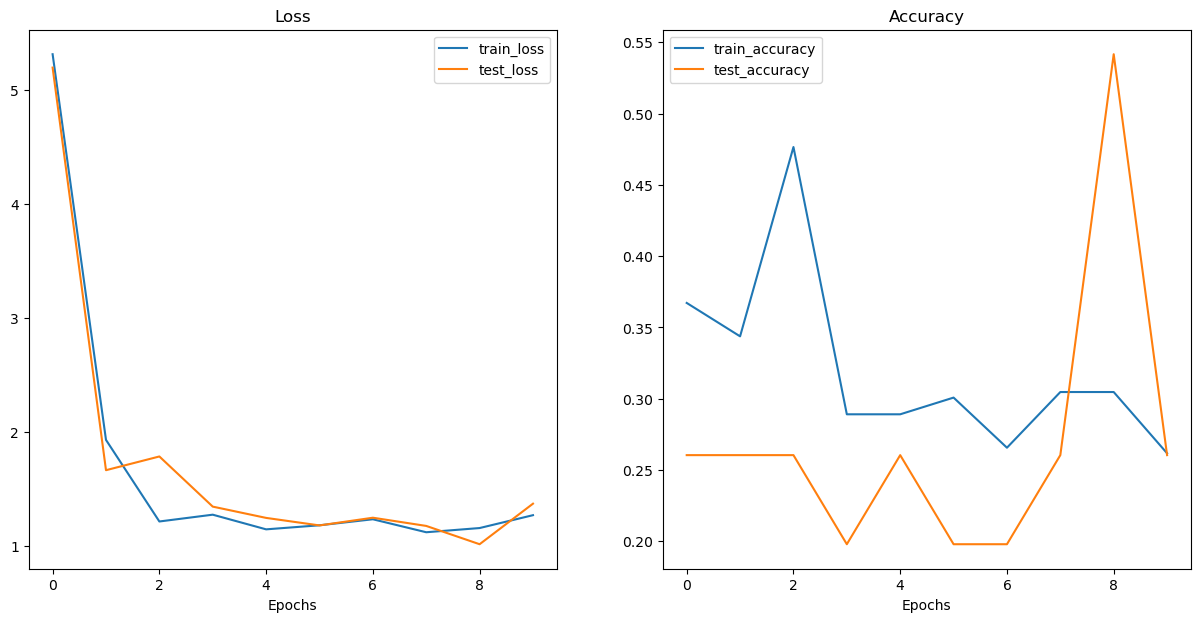

In [19]:
# Plot our ViT model's loss curves
plot_loss_curves(results)

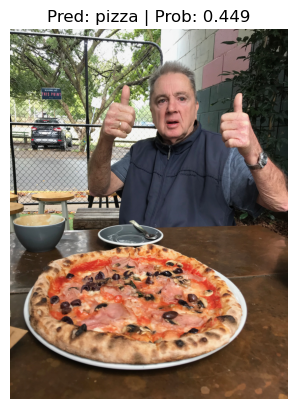

In [25]:
# Import function to make predictions on images and plot them

# Setup custom image path
custom_image_path = "./data/pizza_steak_sushi/04-pizza-dad.jpeg"

# Predict on custom image
pred_and_plot_image(model=vit, image_path=custom_image_path,
                    class_names=class_names)

## Get model Pretrained


In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

In [ ]:
# model pretrained vit
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

In [ ]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir=train_dir, test_dir=test_dir, transform=pretrained_vit_transforms, batch_size=32) 


In [ ]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

In [ ]:
plot_loss_curves(pretrained_vit_results)

In [ ]:
# 27